In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from config import *
from functions import *
from sim import *
from read_ramses import *
from scipy.interpolate import interp1d
from scipy.special import erfinv
import const


In [12]:
def make_frame(data, extent, cmap=None, vmin=None, vmax=None, cbar_step=None, cbar_label=None, do_log=None):

    # create figure and axes
    if do_log: data = np.log10(data + 1e-30)
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_axes([0, 0, 1, 1])
    ax2 = fig.add_axes([0, 1, 1, 0.3])
    cax = fig.add_axes([1, 0, 0.05, 1])
    
    # create image
    im = ax1.imshow(data, cmap=cmap, interpolation='nearest', origin='lower', extent=extent, vmin=vmin, vmax=vmax)
    
    # create colorbar
    cbar_ticks = np.arange(vmin, vmax + cbar_step/2, cbar_step)
    cbar = plt.colorbar(im, ax=ax1, cax=cax, ticks=cbar_ticks)
    cbar.set_label(label=cbar_label, fontsize=16)

    # compute time
    time = aexp_to_proper_time(aexp)
    
    # plot SFR
    ax2.plot(time1d, SFR1d/(const.M_sol/const.yr))
    ax2.axvline(x=time, lw=2, color='red')
    plt.setp(ax2.get_xticklabels(), visible=False)

    # create axes labels and title
    ax1.set_xlabel(r"$%s$ " % ['x', 'y', 'z'][coord1_idx] + unit_latex, fontsize=16)
    ax1.set_ylabel(r"$%s$ " % ['x', 'y', 'z'][coord2_idx] + unit_latex, fontsize=16)
    ax2.set_ylabel(r'SFR [$M_\odot/{\rm yr^{-1}}$]', fontsize=16)
    ax2.set_title(r"$t = %.4f~{\rm Myr}$" % (time / const.Myr), fontsize=16)
    
    return fig


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


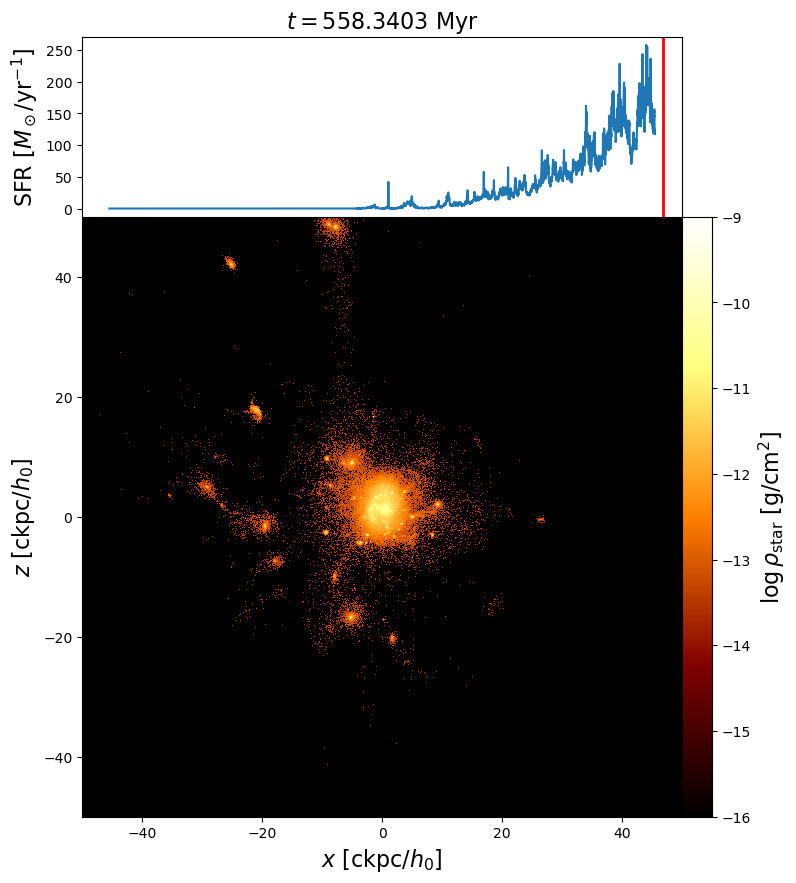

In [14]:
round = 9
sim_name = 'fiducial'
idx_proj = 1
var = 'stars'
coord1_idx, coord2_idx = np.sort([(idx_proj+1)%3, (idx_proj+2)%3])
boxlen = 100 * const.Mpc / const.h0 # box size [Mpc/h0]
unit = const.kpc / const.h0
unit_latex = r'[${\rm ckpc}/h_0$]'

size = 96
rank = 96

move_to_sim_dir(round, sim_name, do_print=True)
stardata = SimpleNamespace(**np.load('starcat/data.npz'))
time1d = stardata.time1d
SFR1d = stardata.starmass_hist1d / np.diff(stardata.time1d)[0]
os.chdir('movie%d' % (idx_proj+1))

mapfile_list = [filename for filename in sorted(os.listdir()) if filename.startswith(var) and filename.endswith('.map')]
num_mapfile = len(mapfile_list)
nmapfile_per_process = int(np.ceil(num_mapfile / size))
idx_mapfile_min = min(rank * nmapfile_per_process, num_mapfile-1)
idx_mapfile_max = min((rank + 1) * nmapfile_per_process, num_mapfile)

idx_mapfile = idx_mapfile_min
mapfile = mapfile_list[idx_mapfile]

# plot settings
plot_settings = {
    "dens": dict(cmap='inferno', vmin=0, vmax=7, cbar_step=1, cbar_label=r'$\log \rho$ [${\rm H/cm^2}$]', do_log=True),
    "dm": dict(cmap='cividis', vmin=-14, vmax=-11, cbar_step=1, cbar_label=r'$\log \rho_{\rm dm}$ [${\rm g/cm^2}$]', do_log=True),
    "stars": dict(cmap='afmhot', vmin=-16, vmax=-9, cbar_step=1, cbar_label=r'$\log \rho_{\rm star}$ [${\rm g/cm^2}$]', do_log=True)
}
    
# read map file
with FortranFile(mapfile, 'r') as f:
    aexp, dx, dy, dz = f.read_reals('f8')
    nx, ny = f.read_ints('i')
    data = f.read_reals('f4')
data = np.array(data).reshape(ny, nx)
    
# calculate frame size
size_img_coord1 = [dx, dy, dz][coord1_idx] * boxlen / unit # frame size [kpc/h0]
size_img_coord2 = [dx, dy, dz][coord2_idx] * boxlen / unit # frame size [kpc/h0]
extent = [-size_img_coord1/2, size_img_coord1/2, -size_img_coord2/2, size_img_coord2/2]

fig = make_frame(data, extent, **plot_settings[var]);
